# HubMap- Hacking the Kidney
#### Goal - Mapping the human body at function tissue unit level - detect glomeruli FTUs in kidney

#### Implementation of Kaggle Notebook - Innovation Prize Winner - Deep Flash2 

#### Create segmentations masks from RLE and probability density function (PDF) for efficient sampling from mask and anatmical structure

Link - https://www.kaggle.com/matjes/hubmap-efficient-sampling-ii-deepflash2#HuBMAP-masks-and-probability-density-function


**Inputs**
- RLE glumeroli segmentations ([challenge dataset](https://www.kaggle.com/c/hubmap-kidney-segmentation/data))
- Anatomical region masks ([.zarr converted](https://www.kaggle.com/matjes/hubmap-anatomy-zarr))
    - Values: 0=other, 1=cortex, 2=medulla
    

**Settings**

The name of the notbook contains the parameters of the probability density function. 
Glumeroli pixels are fixed with a sampling weight of 1. Then, for instance, *pdf_0.5_0.25_0.01* means:

- Sampling weight for cortex regions (`cortex_value`): 0.5 
- Sampling weight for medulla regions (`medulla_value`): 0.25
- Sampling weight for other regions (`fbr`, foreground-background-ratio): 0.01       

###### Step 1 - Install useful libraries

In [1]:
# Install zarr and load packages
# !pip install -qq zarr
import cv2, zarr, gc
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from pathlib import Path
gc.enable()

In [2]:
# from https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T

##### Step 2 - Set paths and configuration

In [22]:
path = Path(r'C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\hubmap_colon_data\Colon_data_reprocessed\Colon_data_reprocessed')
df_train = pd.read_csv(path/"train.csv")
df_info = pd.read_csv(path/"HuBMAP-20-dataset_information.csv")
grp_pdf = zarr.open_group('images_scale2/')

class CONFIG:
    scale = 2        # Downscale final mask by factor 2
    cdf_size = 512   # Downscale CDF for memory efficient loading during training
    bg_p = 0.1       # Background Probability
    cortex_p = 0.7   # Cortex Probability
    medulla_p = 0.2  # Medulla Probability
    
cfg = CONFIG()

# Output
root = zarr.group(f'masks_scale{cfg.scale}')
# Saving cdf in 'pdfs' due to naming conventions for sampling during training in deepflash2
g_msk, g_pdf, g_cdf = root.create_groups('labels', 'pdfs', 'cdfs', overwrite=True)

In [23]:
df_info

,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
0,CL_HandE_1234_B004_bottomleft,4704,4536,aa05346ff-anatomical-structure.json,aa05346ff.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,80,20
1,CL_HandE_1234_B004_bottomright,4704,4536,afa5e8098-anatomical-structure.json,afa5e8098.json,67377,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45
2,CL_HandE_1234_B004_topleft,4704,4536,54f2eec69-anatomical-structure.json,54f2eec69.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25
3,CL_HandE_1234_B004_topright,4704,4536,d488c759a-anatomical-structure.json,d488c759a.json,68138,White,Not Hispanic or Latino,Female,66,81.5,158.8,32.2,Left,100,0
4,HandE_B005_CL_b_RGB_bottomleft,4704,4536,1e2425f28-anatomical-structure.json,1e2425f28.json,63921,White,Not Hispanic or Latino,Male,48,131.5,193.0,35.3,Right,65,35
5,HandE_B005_CL_b_RGB_bottomright,4704,4536,e79de561c-anatomical-structure.json,e79de561c.json,67026,Black or African American,Not Hispanic or Latino,Male,53,73.0,166.0,26.5,Left,55,45
6,HandE_B005_CL_b_RGB_topleft,4704,4536,c68fe75ea-anatomical-structure.json,c68fe75ea.json,67112,White,Not Hispanic or Latino,Male,56,91.2,167.6,32.5,Left,80,20
7,HandE_B005_CL_b_RGB_topright,4704,4536,095bf7a1f-anatomical-structure.json,095bf7a1f.json,68250,White,Not Hispanic or Latino,Female,44,71.7,160.0,28.0,Right,65,35


In [26]:
df_train

,id,encoding
0,CL_HandE_1234_B004_bottomright,12972850 36 12977382 42 12981914 47 12986448 5...
1,CL_HandE_1234_B004_topleft,2023885 36 2028419 40 2032953 44 2037487 47 20...
2,CL_HandE_1234_B004_topright,372094 8 376628 12 381163 14 385698 16 390233 ...
3,HandE_B005_CL_b_RGB_bottomright,2247721 26 2252254 31 2256788 34 2261323 36 22...
4,HandE_B005_CL_b_RGB_topleft,366048 27 370578 43 375111 48 379646 52 384181...


In [25]:
df_train = df_train.rename(columns={"predicted":"encoding"})
df_train = df_train[df_train.id != 'HandE_B005_CL_b_RGB_topright']

In [28]:
df_train.index = df_train.id

###### Step 3 - Repeat for all images

CL_HandE_1234_B004_bottomright
                       image_file  width_pixels  height_pixels  \
1  CL_HandE_1234_B004_bottomright          4704           4536   

  anatomical_structures_segmention_file glomerulus_segmentation_file  \
1   afa5e8098-anatomical-structure.json               afa5e8098.json   

   patient_number   race               ethnicity     sex  age  \
1           67377  White  Not Hispanic or Latino  Female   58   

   weight_kilograms  height_centimeters  bmi_kg/m^2 laterality  \
1              59.0               160.0        23.0      Right   

   percent_cortex  percent_medulla  
1              55               45  
CL_HandE_1234_B004_bottomright with shape (4536, 4704)
Scaling to (2352, 2268)
Getting glomeruli stats
Found 34 glomeruli


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


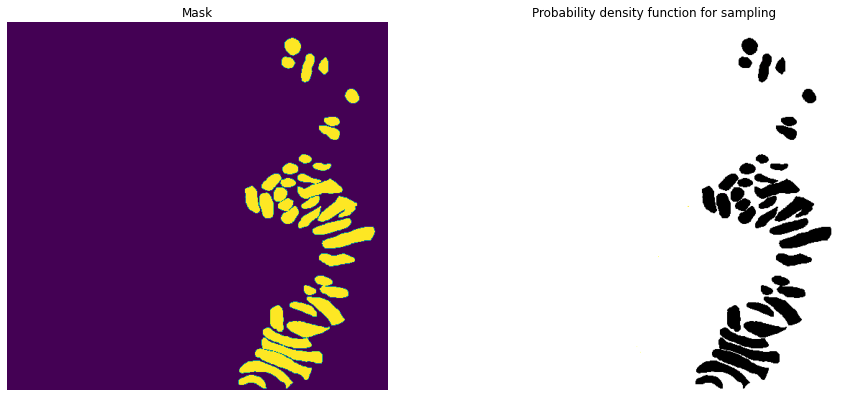

CL_HandE_1234_B004_topleft
                   image_file  width_pixels  height_pixels  \
2  CL_HandE_1234_B004_topleft          4704           4536   

  anatomical_structures_segmention_file glomerulus_segmentation_file  \
2   54f2eec69-anatomical-structure.json               54f2eec69.json   

   patient_number                       race               ethnicity   sex  \
2           67548  Black or African American  Not Hispanic or Latino  Male   

   age  weight_kilograms  height_centimeters  bmi_kg/m^2 laterality  \
2   58              79.9               190.5        22.0      Right   

   percent_cortex  percent_medulla  
2              75               25  
CL_HandE_1234_B004_topleft with shape (4536, 4704)
Scaling to (2352, 2268)
Getting glomeruli stats
Found 85 glomeruli


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


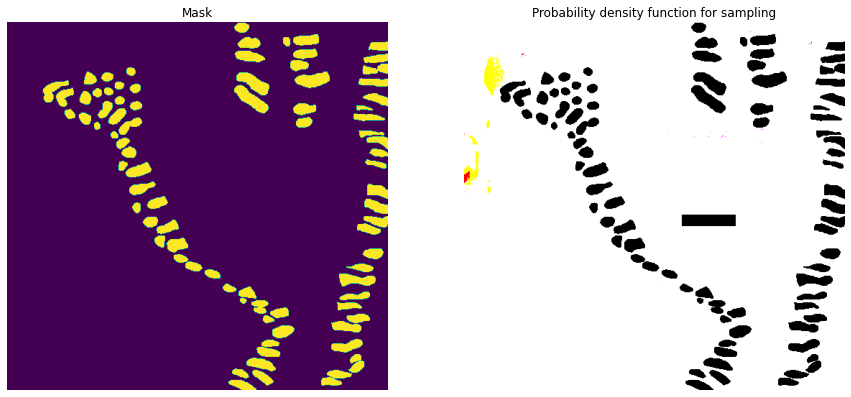

CL_HandE_1234_B004_topright
                    image_file  width_pixels  height_pixels  \
3  CL_HandE_1234_B004_topright          4704           4536   

  anatomical_structures_segmention_file glomerulus_segmentation_file  \
3   d488c759a-anatomical-structure.json               d488c759a.json   

   patient_number   race               ethnicity     sex  age  \
3           68138  White  Not Hispanic or Latino  Female   66   

   weight_kilograms  height_centimeters  bmi_kg/m^2 laterality  \
3              81.5               158.8        32.2       Left   

   percent_cortex  percent_medulla  
3             100                0  
CL_HandE_1234_B004_topright with shape (4536, 4704)
Scaling to (2352, 2268)
Getting glomeruli stats
Found 37 glomeruli


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


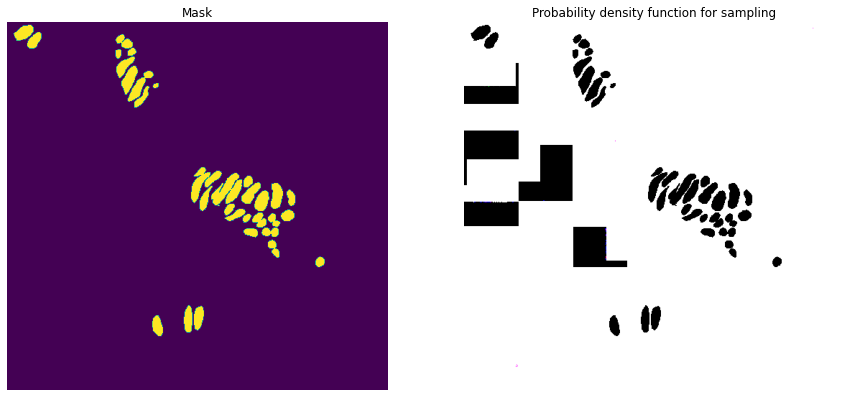

HandE_B005_CL_b_RGB_bottomright
                        image_file  width_pixels  height_pixels  \
5  HandE_B005_CL_b_RGB_bottomright          4704           4536   

  anatomical_structures_segmention_file glomerulus_segmentation_file  \
5   e79de561c-anatomical-structure.json               e79de561c.json   

   patient_number                       race               ethnicity   sex  \
5           67026  Black or African American  Not Hispanic or Latino  Male   

   age  weight_kilograms  height_centimeters  bmi_kg/m^2 laterality  \
5   53              73.0               166.0        26.5       Left   

   percent_cortex  percent_medulla  
5              55               45  
HandE_B005_CL_b_RGB_bottomright with shape (4536, 4704)
Scaling to (2352, 2268)
Getting glomeruli stats
Found 38 glomeruli


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


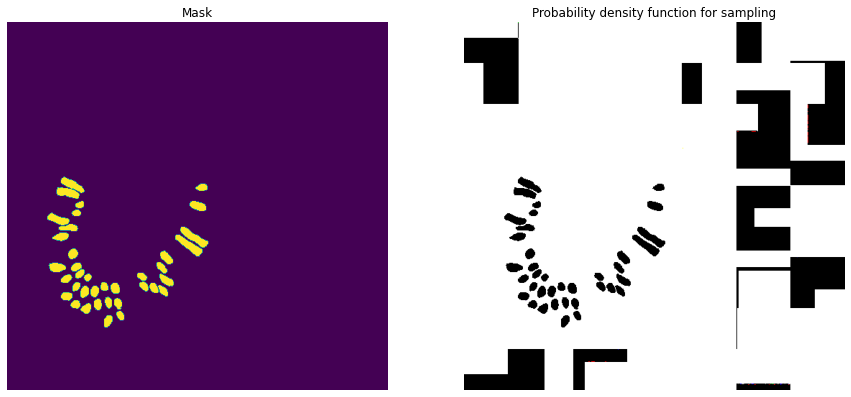

HandE_B005_CL_b_RGB_topleft
                    image_file  width_pixels  height_pixels  \
6  HandE_B005_CL_b_RGB_topleft          4704           4536   

  anatomical_structures_segmention_file glomerulus_segmentation_file  \
6   c68fe75ea-anatomical-structure.json               c68fe75ea.json   

   patient_number   race               ethnicity   sex  age  weight_kilograms  \
6           67112  White  Not Hispanic or Latino  Male   56              91.2   

   height_centimeters  bmi_kg/m^2 laterality  percent_cortex  percent_medulla  
6               167.6        32.5       Left              80               20  
HandE_B005_CL_b_RGB_topleft with shape (4536, 4704)
Scaling to (2352, 2268)
Getting glomeruli stats
Found 31 glomeruli


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


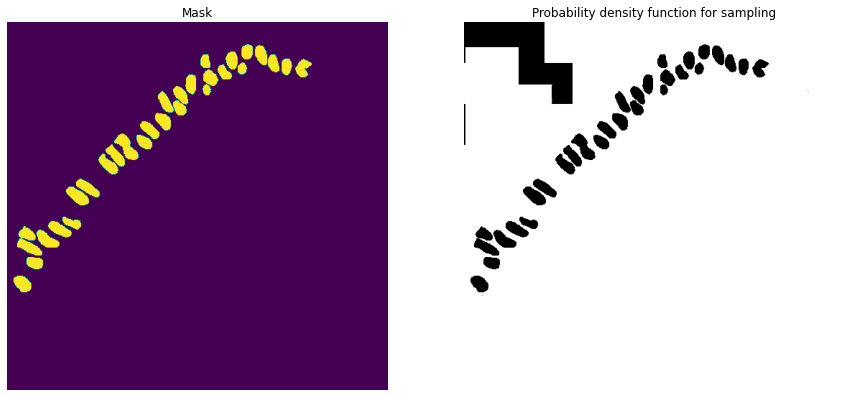

cy           cx  left   top  \
idx                            index                                         
CL_HandE_1234_B004_bottomright 0      1763.353125   150.542281  1713    99   
                               1      1855.790984   282.086506  1815   193   
                               2      1734.037932   249.612130  1695   214   
                               3      1956.836915   271.485461  1923   215   
                               4      2130.578245   456.452286  2087   410   
...                                           ...          ...   ...   ...   
HandE_B005_CL_b_RGB_topleft    25      124.010706  1307.721979    71  1258   
                               26      247.096241  1343.458110   182  1280   
                               27      136.997785  1389.267804    61  1332   
                               28      171.262852  1483.713127   118  1446   
                               29       96.196463  1612.960998    40  1564   

                                      width  height   area  
idx                            index                        
CL_HandE_1234_B004_bottomright 0        101     107   8337  
                               1         86     180  10138  
                               2         83      72   4798  
                               3         63     110   4746  
                               4         89      91   5994  
...                                     ...     ...    ...  
HandE_B005_CL_b_RGB_topleft    25       106      90   6165  
                               26       143     113   9310  
                               27       158     109   9029  
                               28       105      78   6536  
                               29       111     104   8256  

[220 rows x 7 columns]

In [29]:
df_list = []
for idx, row in df_train.iterrows():
    print (idx)
    # Get image info
    img_info = df_info[df_info.image_file==f'{idx}']
    print (img_info)
    shape = (img_info.height_pixels.values[0], img_info.width_pixels.values[0])
    print(idx, 'with shape', shape)
    
    msk = rle2mask(row.encoding, (shape[1], shape[0])).astype('uint8')
    
    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(15,15))
    resize_w = int((msk.shape[1]/msk.shape[0])*cfg.cdf_size)
    ax[0].imshow(cv2.resize(msk, dsize=(resize_w, cfg.cdf_size)))
    ax[0].set_title('Mask')
    ax[0].set_axis_off()
    
    pdf = grp_pdf[idx][:]
    
    if cfg.scale!=1:
        new_size = (msk.shape[1] // cfg.scale, msk.shape[0] // cfg.scale)
        print('Scaling to', new_size)
        msk = cv2.resize(msk, new_size)
        pdf = cv2.resize(pdf, new_size)
        
    pdf = pdf.astype('float32')          
    pdf[pdf==0] = cfg.bg_p/np.sum(pdf==0)
    pdf[msk>0] = 0
    pdf[pdf==1] = cfg.cortex_p/np.sum(pdf==1)
    pdf[pdf==2] = cfg.medulla_p/np.sum(pdf==2)    
      
    print('Getting glomeruli stats')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(msk, connectivity=4)
    print(f'Found {nb_components} glomeruli')
    df_centroids = pd.DataFrame(centroids[1:], columns=['cy', 'cx'])
    df_centroids = df_centroids.join(pd.DataFrame(stats[1:], columns=['left', 'top', 'width', 'height', 'area']))
    df_centroids['idx'] = idx 
    df_centroids.reset_index(inplace=True)
    df_centroids.set_index(['idx', 'index'], inplace=True)
    df_list.append(df_centroids)
    
    # Saving 
    g_msk[idx] = msk
    g_pdf[idx] = pdf
    
    # Saving cdf
    pdf = cv2.resize(pdf, dsize=(resize_w, cfg.cdf_size))      
    g_cdf[idx] = np.cumsum(pdf/np.sum(pdf)) 
            
    ax[1].imshow(pdf)
    ax[1].set_title('Probability density function for sampling')
    ax[1].set_axis_off() 
    plt.show()


df_stats = pd.concat(df_list)
df_stats.to_csv(f'masks_scale{cfg.scale}/roi_stats.csv')
df_stats